# PSG(ECG) classification with a Transformer model

**Author:** Malak Almarshad
**Date created:** 2023/01/31<br>
**Last modified:** 2023/02/10<br>
**Description:** This notebook demonstrates how to do classify (ECG channel) from PSG, timeseries classification using a Transformer model (only encoder part + learnable positional embedding with autoencoder).


# Learned positional embeddings with Autoencoder Transformer model (model_5)

# Importing different dependencies


In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import datetime
import tensorflow_addons as tfa
from sklearn import preprocessing, model_selection

from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

# Making sure that the code runes in GPU

In [2]:
#list all CPUs and GPUs
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16307694258952283251
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5711593472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10088620743915539211
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)

# Hyperparameter

In [4]:
batch_size=32 #32


# Registering start time of the experiment

In [5]:
#logging date and time
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")

In [6]:
current_time=current_time.replace(" ", "_")

In [7]:
current_time=current_time.replace(":", "_")

In [8]:
current_time

'2023-02-28_10_54_00'

## Load the dataset



In [9]:
import pickle

#part of the dataset
#path = "C:\\Users\\MalakAlmarshad\\Desktop\\premirly dataset for experiment\\ICUecgtiny.pkl"

#complete dataset
path = "C:\\Users\\MalakAlmarshad\\Desktop\\premirly dataset for experiment\\ICUecgAll.pkl"

# Loading the dataset
with open(path, 'rb') as file:
    dataset = pickle.load(file)
    
#print first samples
display(dataset.head())
#print dataset information
display(dataset.dtypes)

patient  timestamp_datetime  SpO2(%)  \
0       1 2019-07-29 21:00:36      NaN   
1       1 2019-07-29 21:00:37      NaN   
2       1 2019-07-29 21:00:38      NaN   
3       1 2019-07-29 21:00:39      NaN   
4       1 2019-07-29 21:00:40      NaN   

                                       signal_ecg_ii event  anomaly  
0  [122, 121, 121, 120, 120, 122, 123, 124, 125, ...  NONE    False  
1  [123, 124, 123, 123, 123, 122, 123, 123, 123, ...  NONE    False  
2  [123, 124, 124, 124, 124, 124, 124, 124, 124, ...  NONE    False  
3  [126, 126, 126, 126, 126, 125, 126, 126, 126, ...  NONE    False  
4  [128, 127, 126, 125, 126, 127, 126, 125, 125, ...  NONE    False

patient                       object
timestamp_datetime    datetime64[ns]
SpO2(%)                      float64
signal_ecg_ii                 object
event                         object
anomaly                      boolean
dtype: object

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [11]:
dataset

patient  timestamp_datetime  SpO2(%)  \
0            1 2019-07-29 21:00:36      NaN   
1            1 2019-07-29 21:00:37      NaN   
2            1 2019-07-29 21:00:38      NaN   
3            1 2019-07-29 21:00:39      NaN   
4            1 2019-07-29 21:00:40      NaN   
...        ...                 ...      ...   
961352       9 2019-09-06 06:16:54     95.0   
961353       9 2019-09-06 06:16:55     95.0   
961354       9 2019-09-06 06:16:56     95.0   
961355       9 2019-09-06 06:16:57     95.0   
961356       9 2019-09-06 06:16:58     95.0   

                                            signal_ecg_ii event  anomaly  
0       [122, 121, 121, 120, 120, 122, 123, 124, 125, ...  NONE    False  
1       [123, 124, 123, 123, 123, 122, 123, 123, 123, ...  NONE    False  
2       [123, 124, 124, 124, 124, 124, 124, 124, 124, ...  NONE    False  
3       [126, 126, 126, 126, 126, 125, 126, 126, 126, ...  NONE    False  
4       [128, 127, 126, 125, 126, 127, 126, 125, 125, ...  NONE    False  
...                                                   ...   ...      ...  
961352  [125, 124, 125, 127, 129, 131, 132, 133, 134, ...  NONE    False  
961353  [122, 120, 121, 122, 122, 123, 122, 123, 122, ...  NONE    False  
961354  [123, 122, 123, 123, 122, 122, 123, 122, 123, ...  NONE    False  
961355  [122, 124, 124, 125, 126, 126, 126, 128, 128, ...  NONE    False  
961356  [120, 121, 122, 122, 123, 119, 123, 123, 123, ...  NONE    False  

[961357 rows x 6 columns]

In [12]:
#replace NAN values with 0
dataset=dataset.fillna(0)

In [13]:
display(dataset.head())

patient  timestamp_datetime  SpO2(%)  \
0       1 2019-07-29 21:00:36      0.0   
1       1 2019-07-29 21:00:37      0.0   
2       1 2019-07-29 21:00:38      0.0   
3       1 2019-07-29 21:00:39      0.0   
4       1 2019-07-29 21:00:40      0.0   

                                       signal_ecg_ii event  anomaly  
0  [122, 121, 121, 120, 120, 122, 123, 124, 125, ...  NONE    False  
1  [123, 124, 123, 123, 123, 122, 123, 123, 123, ...  NONE    False  
2  [123, 124, 124, 124, 124, 124, 124, 124, 124, ...  NONE    False  
3  [126, 126, 126, 126, 126, 125, 126, 126, 126, ...  NONE    False  
4  [128, 127, 126, 125, 126, 127, 126, 125, 125, ...  NONE    False

In [14]:
#Defining features (x) and labels (y)
y = dataset["anomaly"]
x = dataset["signal_ecg_ii"]

## Pre-processing


In [15]:
#Scale features (x) according to feature_range.
scaler = preprocessing.MinMaxScaler()
series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in x
]

labels_list = [i for i in y]

C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_data.py:4

In [16]:
#convert the input to one-dimensional vector and replace NAN with zeros
series_list=pd.Series(series_list).fillna(0).tolist()

In [17]:
#Encode categorical features as a one-hot numeric array.
le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(labels_list)
labels_list = le.transform(labels_list)

In [18]:
#print labels after one hot encoding
#labels_list 

In [19]:
#checking if some values are nan, it makes the model to diverge
np.isnan(series_list).any() 


True

In [20]:
np.argwhere(np.isnan(series_list))


array([[ 11552,      0,      0],
       [ 11552,      1,      0],
       [ 11552,      2,      0],
       ...,
       [939526,     77,      0],
       [939526,     78,      0],
       [939526,     79,      0]], dtype=int64)

In [21]:
# worked! converting NAN to num 
series_list=np.nan_to_num(series_list) 

In [22]:
# checking again if some values are nan
np.isnan(series_list).any()


False

In [23]:
##count the names andbnumber of classes
name_classes = le.classes_

In [24]:
n_classes= len(name_classes)

In [25]:
n_classes

2

In [26]:
name_classes

array([False,  True])

In [27]:
#counting the occurrence of a certain class in y
unique, counts = np.unique(labels_list, return_counts=True)


In [28]:
D=dict(zip(unique, counts))

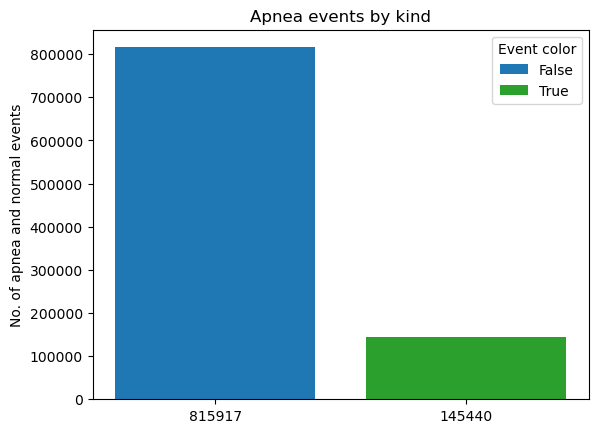

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
bar_labels = name_classes
bars=list(D.values())
x_pos = (np.arange(len(bars)))
bar_colors = ['tab:blue', 'tab:green']
ax.bar(range(len(D)), bars, align='center', label=bar_labels,color=bar_colors )
ax.set_ylabel('No. of apnea and normal events')
ax.set_title('Apnea events by kind')
ax.legend(title='Event color')
# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.show()

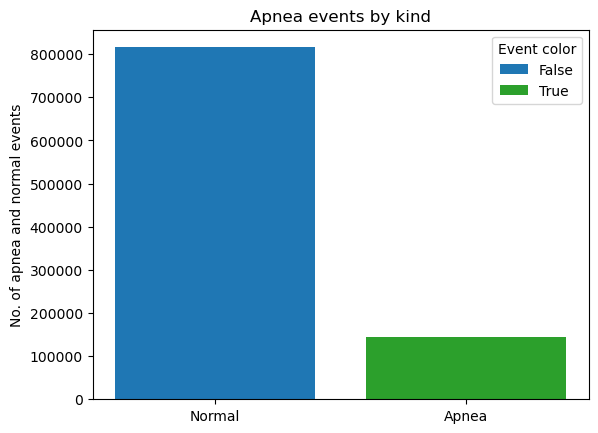

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
bar_labels = name_classes
bars=list(D.values())
x_pos = (np.arange(len(bars)))
bar_colors = ['tab:blue', 'tab:green']
ax.bar(range(len(D)), bars, align='center', label=bar_labels,color=bar_colors )
ax.set_ylabel('No. of apnea and normal events')
ax.set_title('Apnea events by kind')
ax.legend(title='Event color')
# Create names on the x-axis
plt.xticks(x_pos, ['Normal', 'Apnea'])
plt.show()

In [31]:
series_list #print the x after scale

array([[[0.18965517],
        [0.17241379],
        [0.17241379],
        ...,
        [0.15517241],
        [0.18965517],
        [0.20689655]],

       [[0.15625   ],
        [0.171875  ],
        [0.15625   ],
        ...,
        [0.171875  ],
        [0.171875  ],
        [0.171875  ]],

       [[0.21666667],
        [0.23333333],
        [0.23333333],
        ...,
        [0.26666667],
        [0.26666667],
        [0.26666667]],

       ...,

       [[0.11627907],
        [0.09302326],
        [0.11627907],
        ...,
        [0.11627907],
        [0.09302326],
        [0.11627907]],

       [[0.10416667],
        [0.14583333],
        [0.14583333],
        ...,
        [0.10416667],
        [0.10416667],
        [0.125     ]],

       [[0.05882353],
        [0.07843137],
        [0.09803922],
        ...,
        [0.21568627],
        [0.19607843],
        [0.11764706]]])

In [32]:
labels_list #print labels after one hot encoding

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Splitting the dataset into three distinct parts: Train, validate, and test

In [33]:

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    series_list, labels_list, test_size=0.2 ,#shuffle=False#shuffle=True #random_state=42,
)

print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)

#reshape and convert labels (y) to_categorical
#80 is the sampling frequency
x_train = np.asarray(x_train).astype(np.float32).reshape(-1, 80, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, 80, 1)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

Length of x_train : 769085
Length of x_test : 192272
Length of y_train : 769085
Length of y_test : 192272


## Giving different weights to both the majority and minority classes.


In [34]:
vals_dict = {}
for i in labels_list:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

{0: 0.1512861507223643, 1: 0.8487138492776357}


In [35]:
#vocab_size bigger than d_model

In [36]:
latent_dim = 2048
num_heads = 8 #8
vocab_size = 132 #15000 dictionary
embed_dim = 256 #256#less than vocab output
#sequence_length = 80 #20
d_model=32

## Transformer_encoder

For transformer_encoder We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [37]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [38]:
def AutoEncoder(inputs):

    
#     x= layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(inputs)
#     x= layers.Dropout(rate=0.2)(x)
#     x= layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
#     x= layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
#     x= layers.Dropout(rate=0.2)(x)
#     x= layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
#     x= layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    x= layers.Conv1D(filters=132, kernel_size=7, padding="same", strides=2, activation="relu")(inputs)
    x= layers.Dropout(rate=0.1)(x)
    x= layers.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x= layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
#     x= layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
#     x= layers.Dropout(rate=0.2)(x)
#     x= layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
#     x= layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    return (x)


## Building the model

Our model processes a tensor of shape `(batch size, sequence length, features)`, where `sequence length` is the number of time steps and `features` is each input timeseries.



Things you can change:
1.change the number of `transformer_encoder` blocks stack
2.add more or less Multi-Layer Perceptron classification head.
3.A pooling layer `GlobalAveragePooling1D` to reduce the output tensor of the `TransformerEncoder` part 

In [39]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout,
    mlp_dropout,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # AutoEncoder 
    x = AutoEncoder(inputs)
    
    
    print(x)
    # Transformers Encoder layers
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Pooling layer
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Multi-Layer Perceptron classification head.
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)


In [40]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256, #256
    num_heads=4, #4
    ff_dim=4, #10
    num_transformer_blocks=6, #4
    mlp_units=[256],
    mlp_dropout=0.2, #4
    dropout=0.1,
)


KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name=None), name='conv1d_transpose/BiasAdd:0', description="created by layer 'conv1d_transpose'")


In [41]:
#An optimization algorithm finds the value of the parameters(weights) that minimize the error when mapping inputs to outputs.

#optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay = 0.0001)


## Complie everything togather


In [42]:
#hing loss did not work in tiny dataset

model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,#1e-4
    weighted_metrics=["accuracy","Precision", "Recall",
             tf.keras.metrics.BinaryAccuracy(),
             tfa.metrics.F1Score(num_classes=n_classes,average='micro',threshold=0.5),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.SpecificityAtSensitivity(0.5),
             tf.keras.metrics.SensitivityAtSpecificity(0.5),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.Precision(),
             ]
)

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 40, 132)      1056        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 40, 132)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 64)       59200       ['dropout[0][0]']                
                                                                                              

In [44]:
import os
log_dir= "logs/fit/" + current_time

In [45]:
#Learning rate scheduler

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [46]:
#Save model folder name as a checkPoint
checkpoint_path = "training_2/cp.ckpt"

In [47]:
callbacks = [tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0),
tf.keras.callbacks.EarlyStopping( #stopes the model if the val_loss did not improve, to safe time
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,)
    ,

#         keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss",
#         factor=0.2,
#         patience=10,
#         min_lr=0.0,
#     ),
             keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_best_only=True, monitor="val_loss"
    ),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]


In [48]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Train and evaluate

In [49]:
#batch_size=64 is the maximum that my GPU can handle

history= model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=300, #200
    batch_size=batch_size,#32
    callbacks=callbacks,
    #shuffle=False,
    class_weight=weight_dict,
)


Epoch 1/300
19228/19228 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.6387 - precision: 0.6386 - recall: 0.6386 - binary_accuracy: 0.6387 - f1_score: 0.6770 - auc: 0.6899 - specificity_at_sensitivity: 0.7570 - sensitivity_at_specificity: 0.7570 - weighted_recall: 0.6386 - weighted_precision: 0.6386

INFO:tensorflow:Assets written to: training_2\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_2\cp.ckpt\assets


19228/19228 [==============================] - 557s 29ms/step - loss: 0.1640 - accuracy: 0.6387 - precision: 0.6386 - recall: 0.6386 - binary_accuracy: 0.6387 - f1_score: 0.6770 - auc: 0.6899 - specificity_at_sensitivity: 0.7570 - sensitivity_at_specificity: 0.7570 - weighted_recall: 0.6386 - weighted_precision: 0.6386 - val_loss: 0.6731 - val_accuracy: 0.6454 - val_precision: 0.6454 - val_recall: 0.6454 - val_binary_accuracy: 0.6454 - val_f1_score: 0.6454 - val_auc: 0.6508 - val_specificity_at_sensitivity: 0.7508 - val_sensitivity_at_specificity: 0.7508 - val_weighted_recall: 0.6454 - val_weighted_precision: 0.6454 - lr: 0.0010
Epoch 2/300
19227/19228 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.6737 - precision: 0.6737 - recall: 0.6737 - binary_accuracy: 0.6737 - f1_score: 0.6921 - auc: 0.7258 - specificity_at_sensitivity: 0.8091 - sensitivity_at_specificity: 0.8091 - weighted_recall: 0.6737 - weighted_precision: 0.6737

INFO:tensorflow:Assets written to: training_2\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_2\cp.ckpt\assets


19228/19228 [==============================] - 550s 29ms/step - loss: 0.1579 - accuracy: 0.6737 - precision: 0.6737 - recall: 0.6737 - binary_accuracy: 0.6737 - f1_score: 0.6921 - auc: 0.7258 - specificity_at_sensitivity: 0.8091 - sensitivity_at_specificity: 0.8091 - weighted_recall: 0.6737 - weighted_precision: 0.6737 - val_loss: 0.5510 - val_accuracy: 0.7607 - val_precision: 0.7607 - val_recall: 0.7607 - val_binary_accuracy: 0.7607 - val_f1_score: 0.7607 - val_auc: 0.8258 - val_specificity_at_sensitivity: 0.9118 - val_sensitivity_at_specificity: 0.9118 - val_weighted_recall: 0.7607 - val_weighted_precision: 0.7607 - lr: 0.0010
Epoch 3/300
19228/19228 [==============================] - 533s 28ms/step - loss: 0.1570 - accuracy: 0.6783 - precision: 0.6783 - recall: 0.6783 - binary_accuracy: 0.6783 - f1_score: 0.6969 - auc: 0.7303 - specificity_at_sensitivity: 0.8111 - sensitivity_at_specificity: 0.8111 - weighted_recall: 0.6783 - weighted_precision: 0.6783 - val_loss: 0.6151 - val_accur

In [50]:
print(history.history) # printing details for tracking performance

{'loss': [0.16399826109409332, 0.15793178975582123, 0.15696360170841217, 0.1568327397108078, 0.1566232293844223, 0.15646108984947205, 0.15619337558746338, 0.15604135394096375, 0.1561087816953659, 0.15590861439704895, 0.15571188926696777, 0.15547367930412292], 'accuracy': [0.6386504173278809, 0.6736588478088379, 0.6782532930374146, 0.6781046390533447, 0.6788679361343384, 0.6799766421318054, 0.680558443069458, 0.6820183992385864, 0.6816892027854919, 0.6819931268692017, 0.6826690435409546, 0.6845005750656128], 'precision': [0.63864666223526, 0.6736522912979126, 0.6782524585723877, 0.6781050562858582, 0.6788663268089294, 0.6799743175506592, 0.6805552840232849, 0.6820176243782043, 0.68168705701828, 0.6819897294044495, 0.6826669573783875, 0.6844958662986755], 'recall': [0.63864666223526, 0.6736522912979126, 0.6782524585723877, 0.6781050562858582, 0.6788663268089294, 0.6799743175506592, 0.6805552840232849, 0.6820176243782043, 0.68168705701828, 0.6819897294044495, 0.6826669573783875, 0.6844958

## Training Results

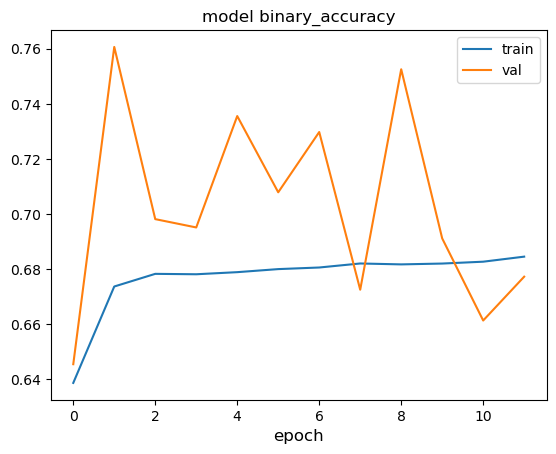

In [51]:
metric = ["binary_accuracy"]
plt.figure()
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model " + "binary_accuracy")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

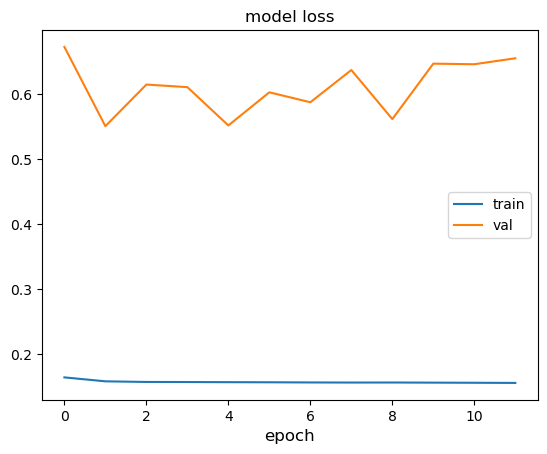

In [52]:
metric = ["loss"]
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model " + "loss")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

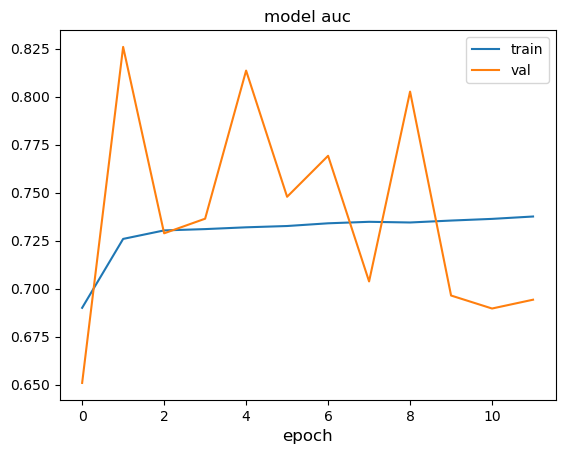

In [53]:
metric = ["tf.keras.metrics.AUC()"]
plt.figure()
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.title("model " + "auc")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

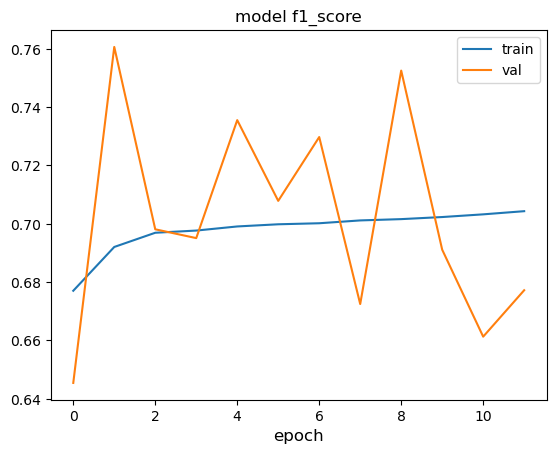

In [54]:
metric = ["f1_score"]
plt.figure()
plt.plot(history.history["f1_score"])
plt.plot(history.history["val_f1_score"])
plt.title("model " + "f1_score")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

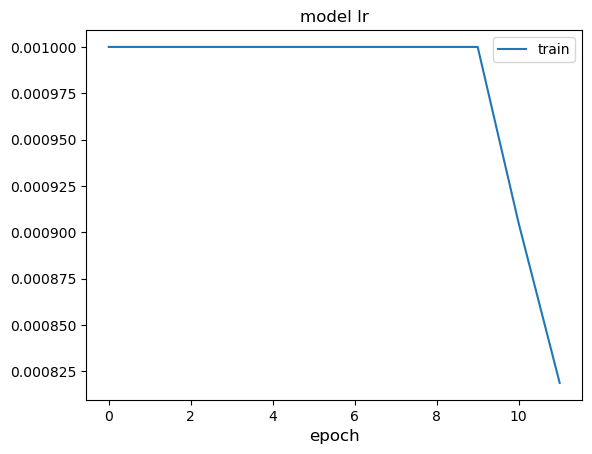

In [55]:
metric = ["lr"]
plt.figure()
plt.plot(history.history["lr"])
plt.title("model " + "lr")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [56]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'binary_accuracy', 'f1_score', 'auc', 'specificity_at_sensitivity', 'sensitivity_at_specificity', 'weighted_recall', 'weighted_precision', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_binary_accuracy', 'val_f1_score', 'val_auc', 'val_specificity_at_sensitivity', 'val_sensitivity_at_specificity', 'val_weighted_recall', 'val_weighted_precision', 'lr'])


In [57]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 4

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(30, 20))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

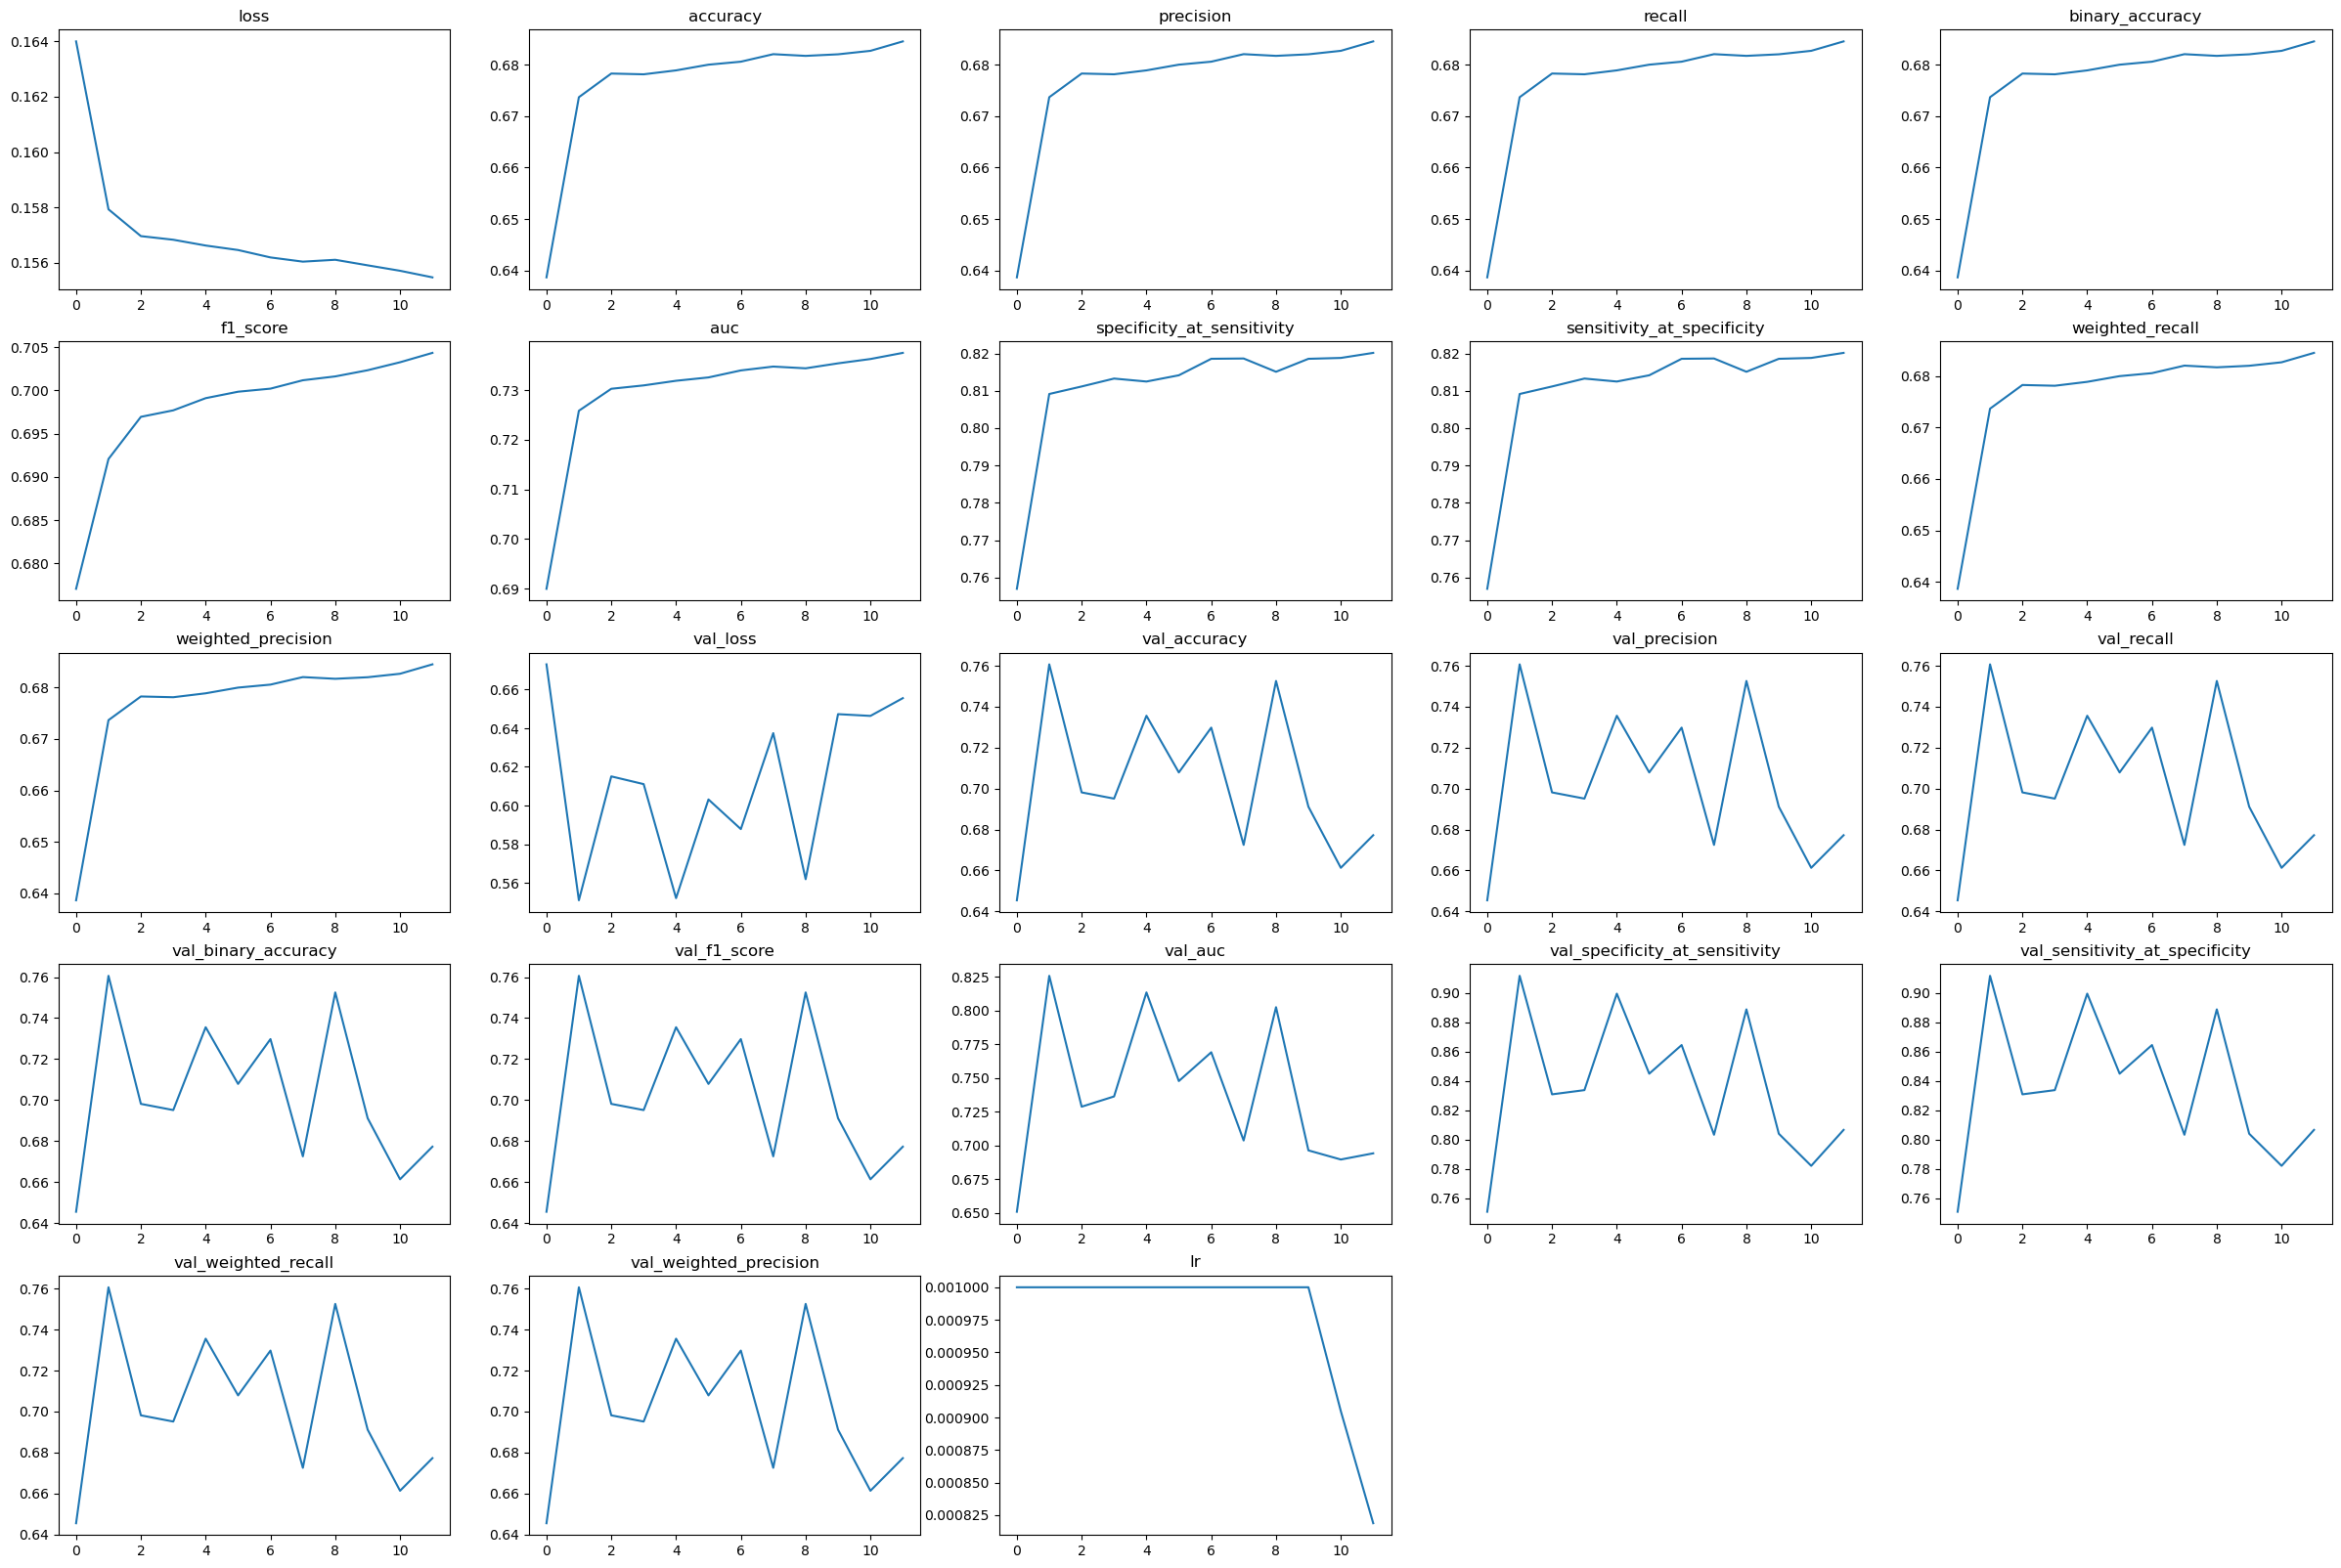

In [58]:
#print all metrics
plot_history_metrics(model.history)


## Testset Results

In [59]:

model.evaluate(x_test, y_test, verbose=1)

6009/6009 [==============================] - 51s 9ms/step - loss: 0.5509 - accuracy: 0.7610 - precision: 0.7610 - recall: 0.7610 - binary_accuracy: 0.7610 - f1_score: 0.7610 - auc: 0.8265 - specificity_at_sensitivity: 0.9098 - sensitivity_at_specificity: 0.9098 - weighted_recall: 0.7610 - weighted_precision: 0.7610


[0.5508760213851929,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.8264673352241516,
 0.9097840785980225,
 0.9097788333892822,
 0.7609584331512451,
 0.7609584331512451]

## Evaluate model on test data

In [60]:
model1 = keras.models.load_model(checkpoint_path)

In [61]:
model.evaluate(x_test, y_test, batch_size=batch_size)



6009/6009 [==============================] - 50s 8ms/step - loss: 0.5509 - accuracy: 0.7610 - precision: 0.7610 - recall: 0.7610 - binary_accuracy: 0.7610 - f1_score: 0.7610 - auc: 0.8265 - specificity_at_sensitivity: 0.9098 - sensitivity_at_specificity: 0.9098 - weighted_recall: 0.7610 - weighted_precision: 0.7610


[0.5508760213851929,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.8264673352241516,
 0.9097840785980225,
 0.9097788333892822,
 0.7609584331512451,
 0.7609584331512451]

In [62]:
#evaluating best model
# seems batch_size on testset does not effect test set performance
model1.evaluate(x_test, y_test, batch_size=batch_size)

6009/6009 [==============================] - 52s 9ms/step - loss: 0.5509 - accuracy: 0.7610 - precision: 0.7610 - recall: 0.7610 - binary_accuracy: 0.7610 - f1_score: 0.7610 - auc: 0.8265 - specificity_at_sensitivity: 0.9098 - sensitivity_at_specificity: 0.9098 - weighted_recall: 0.7610 - weighted_precision: 0.7610


[0.5508760213851929,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.7609584331512451,
 0.8264673352241516,
 0.9097840785980225,
 0.9097788333892822,
 0.7609584331512451,
 0.7609584331512451]

In [63]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=batch_size)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
#print("Generate predictions for 3 samples")
#predictions = model.predict(x_test[:3])
#print("predictions shape:", predictions.shape)

Evaluate on test data
6009/6009 [==============================] - 50s 8ms/step - loss: 0.5509 - accuracy: 0.7610 - precision: 0.7610 - recall: 0.7610 - binary_accuracy: 0.7610 - f1_score: 0.7610 - auc: 0.8265 - specificity_at_sensitivity: 0.9098 - sensitivity_at_specificity: 0.9098 - weighted_recall: 0.7610 - weighted_precision: 0.7610
test loss, test acc: [0.5508760213851929, 0.7609584331512451, 0.7609584331512451, 0.7609584331512451, 0.7609584331512451, 0.7609584331512451, 0.8264673352241516, 0.9097840785980225, 0.9097788333892822, 0.7609584331512451, 0.7609584331512451]


In [64]:
#Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
6009/6009 [==============================] - 31s 5ms/step
predictions shape: (192272, 2)


In [65]:
predictions

array([[0.81282777, 0.18717217],
       [0.05561488, 0.94438505],
       [0.8912143 , 0.10878565],
       ...,
       [0.85336083, 0.14663914],
       [0.79080397, 0.20919605],
       [0.26755098, 0.732449  ]], dtype=float32)

In [66]:
#generate predication to draw a confusion matrix
predicted = model.predict(x_test, batch_size=batch_size)

predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)

6009/6009 [==============================] - 31s 5ms/step


In [67]:
actual = tf.argmax(y_test, axis=1)


In [68]:
x_test

array([[[0.19469027],
        [0.22123894],
        [0.22123894],
        ...,
        [1.        ],
        [0.07079646],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.09345794],
        [0.09345794],
        [0.10280374],
        ...,
        [0.11214953],
        [0.11214953],
        [0.11214953]],

       ...,

       [[0.31578946],
        [0.0877193 ],
        [0.        ],
        ...,
        [0.98245615],
        [1.        ],
        [0.19298245]],

       [[0.65      ],
        [0.7       ],
        [0.9       ],
        ...,
        [0.1       ],
        [0.1       ],
        [0.15      ]],

       [[0.5494506 ],
        [1.        ],
        [0.6703297 ],
        ...,
        [0.03296703],
        [0.03296703],
        [0.03296703]]], dtype=float32)

In [69]:
idx=1

In [70]:
predicted

<tf.Tensor: shape=(192272,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 1], dtype=int64)>

In [71]:
actual

<tf.Tensor: shape=(192272,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 1], dtype=int64)>

In [72]:
labels=name_classes

In [73]:
labels

array([False,  True])

In [74]:

conf_mat = confusion_matrix(actual, predicted) 

print(conf_mat)

[[131212  32093]
 [ 13868  15099]]


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

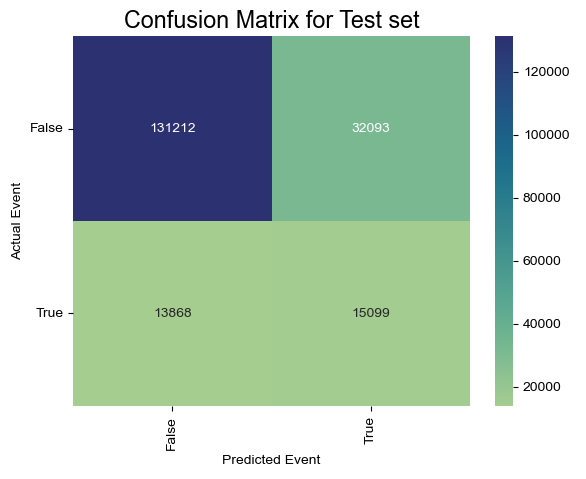

In [75]:
import seaborn as sns
cm = tf.math.confusion_matrix(actual, predicted)
ax = sns.heatmap(cm, annot=True, fmt='g',cmap="crest")
sns.set(rc={'figure.figsize':(12, 12)})
sns.set(font_scale=1.4)
ax.set_title('Confusion Matrix for Test set')
ax.set_xlabel('Predicted Event')
ax.set_ylabel('Actual Event')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [76]:
y_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [77]:
len(y_test)

192272

6009/6009 [==============================] - 31s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.80      0.85    163305
           1       0.32      0.52      0.40     28967

    accuracy                           0.76    192272
   macro avg       0.61      0.66      0.62    192272
weighted avg       0.82      0.76      0.78    192272



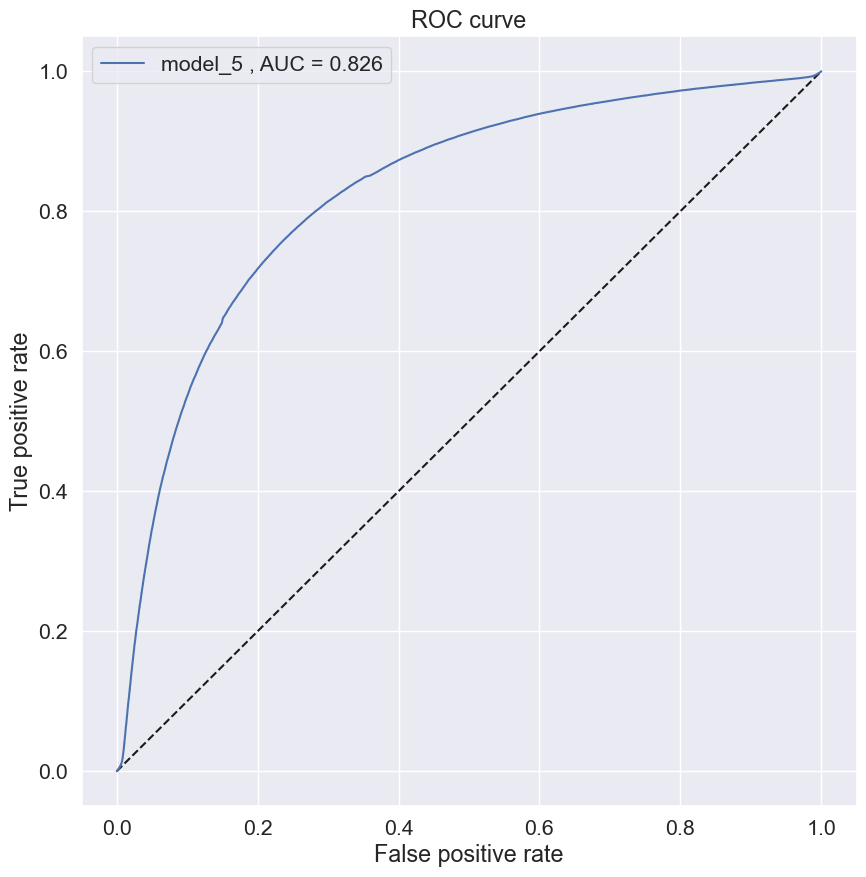

In [78]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')


y_pred = model.predict(x_test)
fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(tf.argmax(y_test, axis=1), y_pred))
plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format("model_5 ", auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();


In [79]:
#actual=np.nan_to_num(actual) # worked 

In [80]:
#predicted=np.nan_to_num(predicted) # worked 

In [81]:
actual = tf.argmax(y_test, axis=1)


In [82]:
predicted

<tf.Tensor: shape=(192272,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 1], dtype=int64)>

In [83]:
actual

<tf.Tensor: shape=(192272,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 1], dtype=int64)>

In [84]:
labels=name_classes

In [85]:
%tensorboard --logdir logs/fit/current_time


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\Scripts\tensorboard.exe\__main__.py", line 4, in <module>
  File "C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\tensorboard\default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "C:\Users\MalakAlmarshad\anaconda3\envs\tensorflow\lib\site-packages\tensorboard\plugins\audio\audio_plugin.py", line 25, in <module>
    from tensorboard.data i

In [86]:
from sklearn.metrics import balanced_accuracy_score #this a reverse of the model accuracy, because we alredy weight the dataset
bal_acc=balanced_accuracy_score(actual, predicted) #if you train the model without weight considration, you can use this metric

In [87]:
bal_acc

0.6623632357120772

In [88]:
good_indices = [0, 3]

In [89]:
property_asel = [predicted[i] for i in good_indices]


In [90]:
print(predicted)

tf.Tensor([0 1 0 ... 0 0 1], shape=(192272,), dtype=int64)


In [91]:
predicted.shape

TensorShape([192272])

In [92]:
print(actual)

tf.Tensor([0 1 0 ... 0 0 1], shape=(192272,), dtype=int64)


In [154]:
spike=actual[:60].numpy()
spike2=predicted[:60].numpy()




In [155]:
spike

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [156]:
spike2

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [157]:
spiky=tf.where(spike).numpy().tolist()
spiky2=tf.where(spike2).numpy().tolist()

In [158]:
flat_list = [item for sublist in spiky for item in sublist]
spiky =flat_list
flat_list2 = [item for sublist in spiky2 for item in sublist]
spiky2 =flat_list2

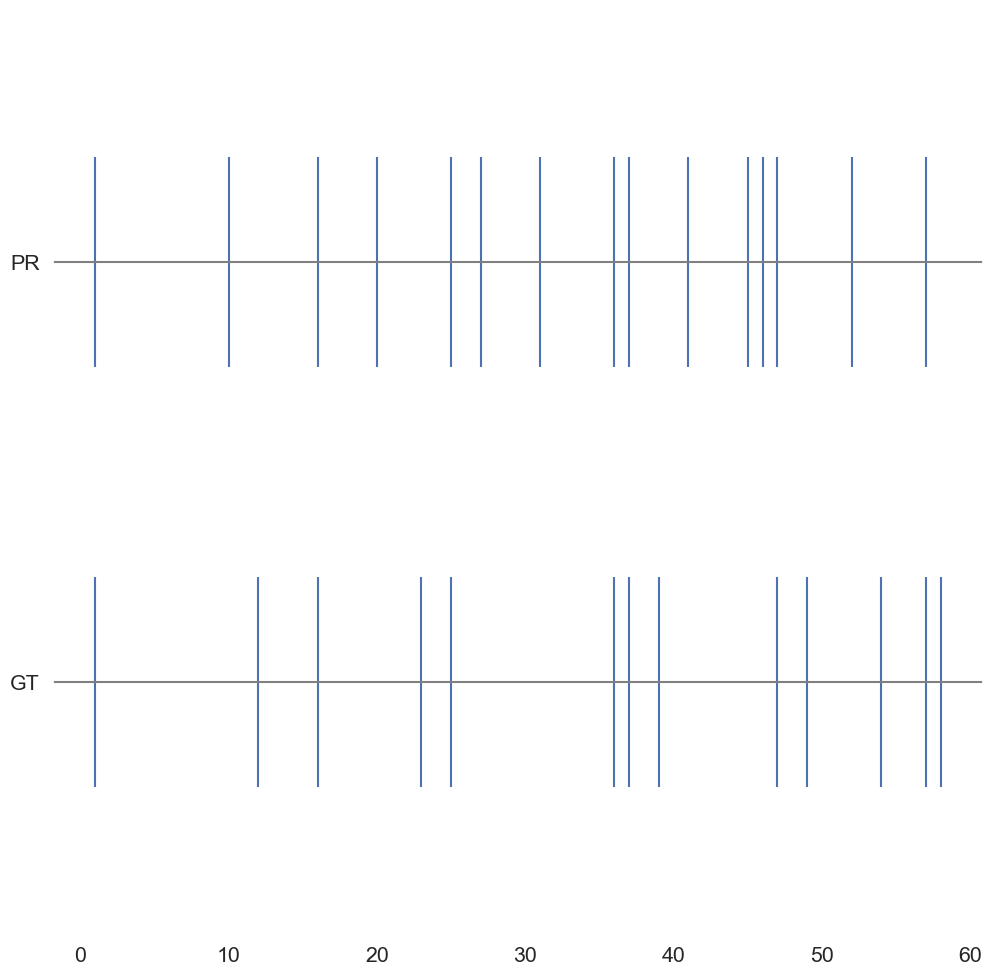

In [160]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt1

plt1.rcParams['axes.grid'] = 'false'

plt1.rcParams['axes.facecolor'] = 'w'

plt1.eventplot(spiky, 
              orientation = 'horizontal',
              linelengths = 0.1, 
              lineoffsets=[0]
              )
plt1.eventplot(spiky2, 
              orientation = 'horizontal',
              linelengths = 0.1,
              lineoffsets=[0.2]
              )
plt1.axhline(y=0.2, color='gray', linestyle='-')
plt1.axhline(y=0, color='gray', linestyle='-')
labels=['GT', 'PD']
plt1.yticks(np.arange(0, 0.2))  # Set label locations.
plt1.yticks([0, 0.2], labels=['GT', 'PR'])  # Set text labels and properties.

plt1.show()

In [99]:
import matplotlib.pyplot as plt

def view_ecg_plot(idx):
    data = x_test[idx, :]
    plt.plot(data)
    print("Actual:"+" ")
    print(actual[idx])
    
    print("Predicted:"+" ")
    print(predicted[idx])
  
    predictedLabel="normal"
    actualLabel="normal"

    if actual[idx]==1 :
        actualLabel="apnea"
    if predicted[idx]==1 :
        predictedLabel="apnea"
    plt.xlabel("Time - 1 sec")
    plt.ylabel("ECG in scaled Volts")
    plt.title("Actual:"+" "+actualLabel+" , "+"Predicted:"+" "+predictedLabel)
    plt.show()




Actual: 
tf.Tensor(0, shape=(), dtype=int64)
Predicted: 
tf.Tensor(0, shape=(), dtype=int64)


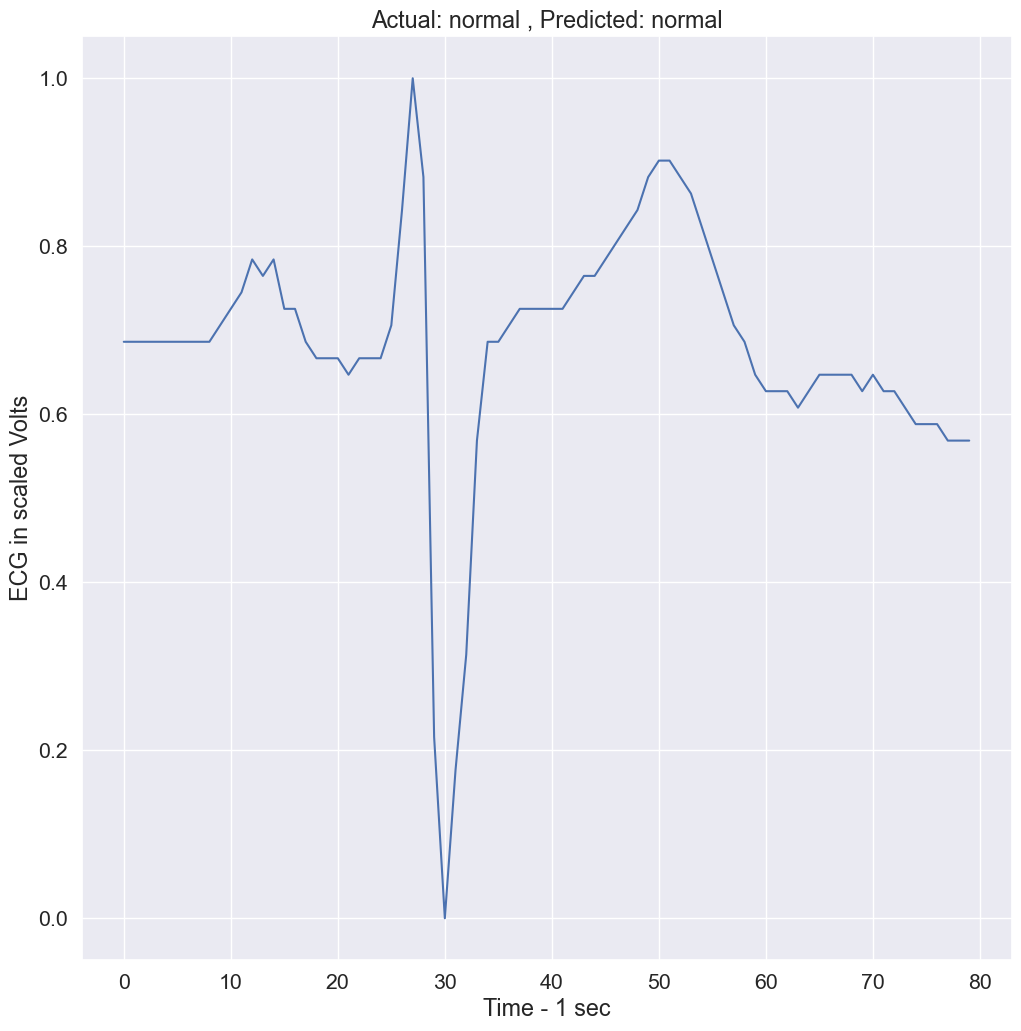

In [100]:
view_ecg_plot(5)

Actual: 
tf.Tensor(0, shape=(), dtype=int64)
Predicted: 
tf.Tensor(0, shape=(), dtype=int64)


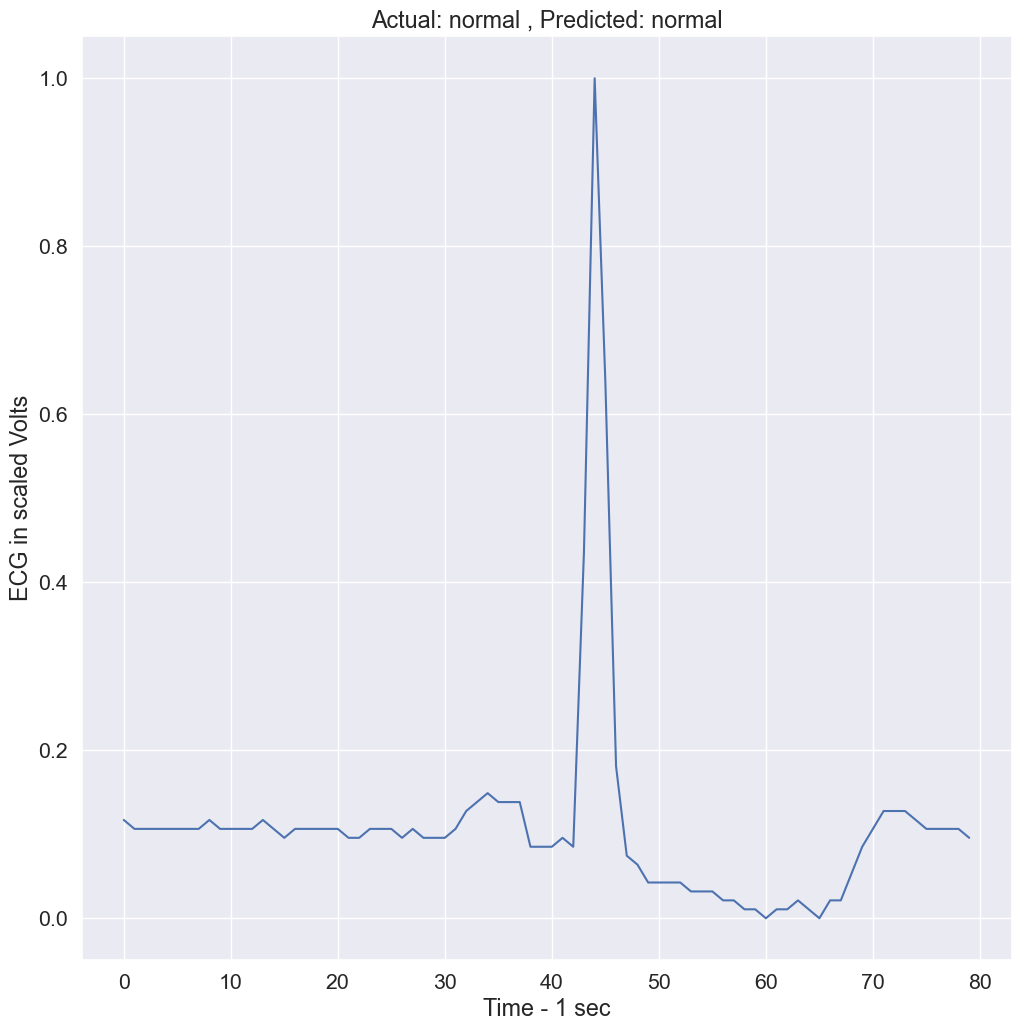

In [101]:
view_ecg_plot(111)

Actual: 
tf.Tensor(0, shape=(), dtype=int64)
Predicted: 
tf.Tensor(1, shape=(), dtype=int64)


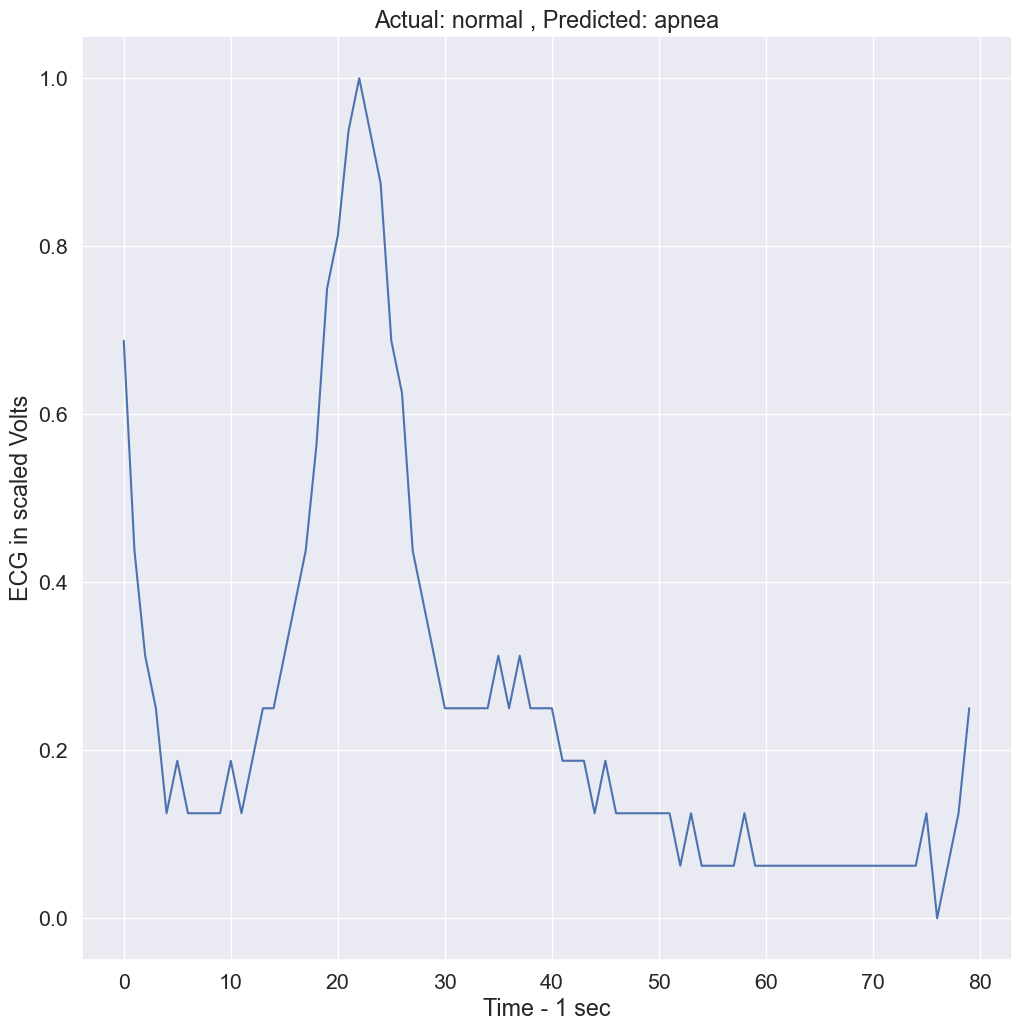

In [102]:
view_ecg_plot(31)

Actual: 
tf.Tensor(0, shape=(), dtype=int64)
Predicted: 
tf.Tensor(0, shape=(), dtype=int64)


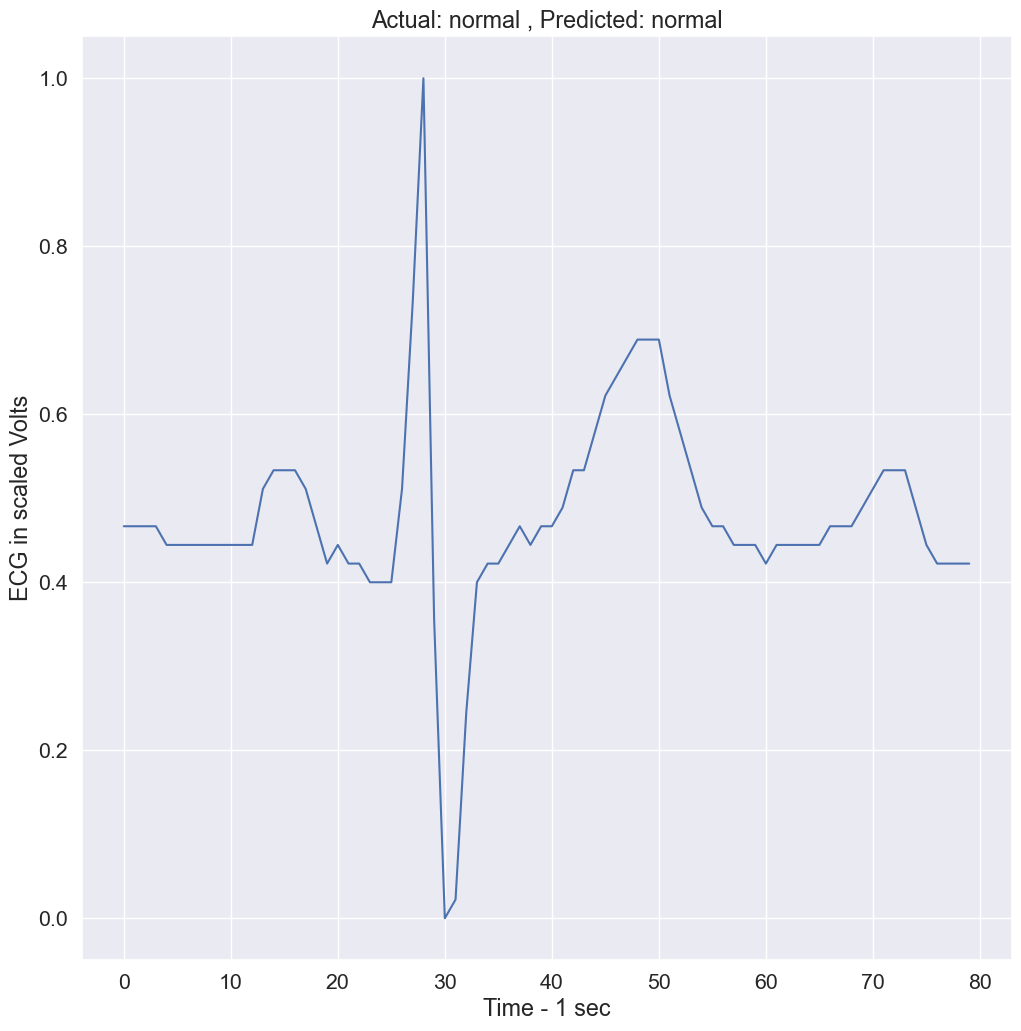

In [103]:
view_ecg_plot(180)

Actual: 
tf.Tensor(0, shape=(), dtype=int64)
Predicted: 
tf.Tensor(1, shape=(), dtype=int64)


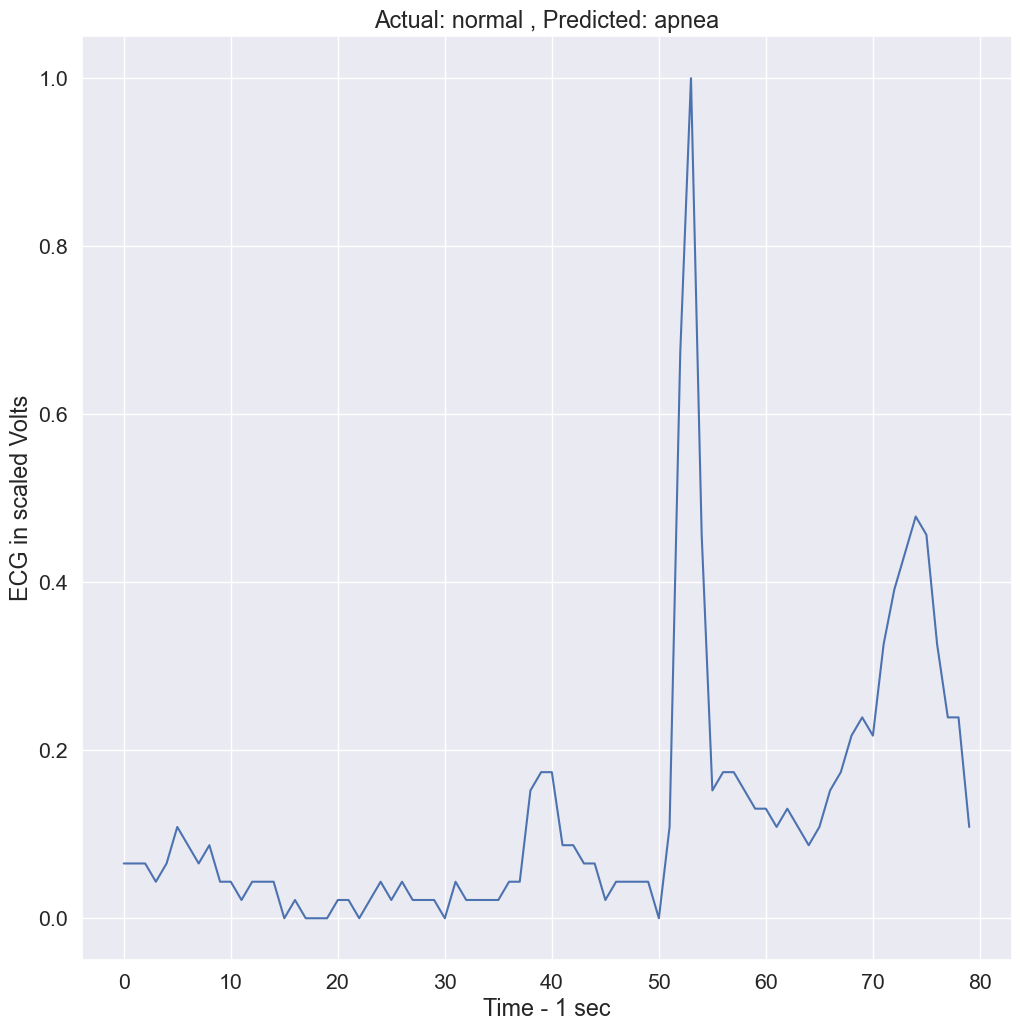

In [104]:
view_ecg_plot(81)

## To build confusion matrix for train

In [105]:
predictedTrain = model.predict(x_train, batch_size=batch_size) #x_train

predictedTrain = tf.concat(predictedTrain, axis=0)
predictedTrain = tf.argmax(predictedTrain, axis=1)

24034/24034 [==============================] - 131s 5ms/step


In [106]:
actualtrain = tf.argmax(y_train, axis=1)

[Text(0, 0.5, 'GT'), Text(0, 1.5, 'PD')]

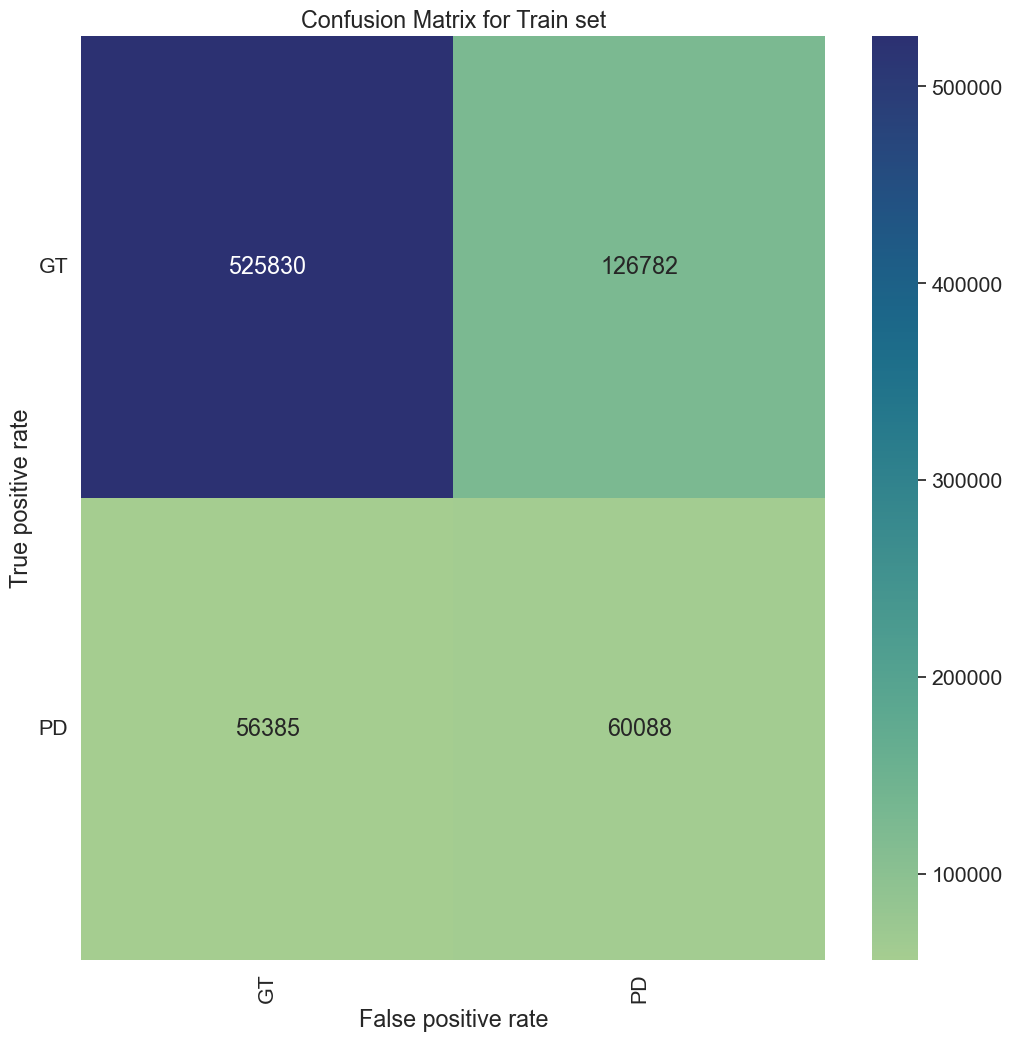

In [107]:
#confusion matrix with 
import seaborn as sns
cm = tf.math.confusion_matrix(actualtrain, predictedTrain)
ax = sns.heatmap(cm, annot=True, fmt='g',cmap="crest")
sns.set(rc={'figure.figsize':(12, 12)})
sns.set(font_scale=1.4)
ax.set_title('Confusion Matrix for Train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [108]:
predictedTrain

<tf.Tensor: shape=(769085,), dtype=int64, numpy=array([1, 0, 1, ..., 0, 0, 0], dtype=int64)>

In [109]:
#Ent of expermint time

In [110]:
current_end_time = now.strftime("%Y-%m-%d %H:%M:%S")

In [111]:
current_end_time

'2023-02-28 10:54:00'